In [2]:
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import sigpy as sp
import sigpy.plot as pl


In [3]:
from warnings import warn

In [4]:
%matplotlib notebook

In [5]:
def rf(FpFmZ, alpha):
    "Same as rf2, but only returns FpFmZ"""
    return rf2(FpFmZ, alpha)[0]
def rf2(FpFmZ, alpha):
    
    """ Propagate EPG states through an RF rotation of 
    alpha (radians). Assumes CPMG condition, i.e.
    magnetization lies on the real x axis.
    
    INPUT: (input should be a torch tensor)
        FpFmZ = 3xN vector of F+, F- and Z states.
        alpha = RF pulse flip angle in radians

    OUTPUT:
        FpFmZ = Updated FpFmZ state.
        RR = RF rotation matrix (3x3).

    """
    if torch.abs(alpha) > 2*np.pi:
        warn('rf2: Flip angle should be in radians! alpha=%f' % alpha)
    cosa2 = torch.cos(alpha/2.)**2
    sina2 = torch.sin(alpha/2.)**2
    cosa = torch.cos(alpha)
    sina = torch.sin(alpha)
    RR = torch.tensor([ [cosa2, sina2, sina],
                    [sina2, cosa2, -sina],
                    [-0.5 * sina, 0.5 * sina, cosa] ])
#     RR = torch.tensor([ [cosa2, sina2, sina],
#                     [sina2, cosa2, -sina],
#                     [-0.5 * sina, 0.5 * sina, cosa] ]).cuda()
    FpFmZ = torch.mm(RR,FpFmZ.float()) # dot in numpy
    return FpFmZ, RR

In [6]:
def rf_ex(FpFmZ, alpha):
    "Same as rf2_ex, but only returns FpFmZ"""
    return rf2_ex(FpFmZ, alpha)[0]
def rf2_ex(FpFmZ, alpha):
    """ Propagate EPG states through an RF excitation of 
    alpha (radians) along the y direction, i.e. phase of pi/2.
    in Pytorch
    INPUT:
        FpFmZ = 3xN vector of F+, F- and Z states.
        alpha = RF pulse flip angle in radians

    OUTPUT:
        FpFmZ = Updated FpFmZ state.
        RR = RF rotation matrix (3x3).

    """

    try:
        alpha = alpha[0]
    except:
        pass


    if torch.abs(alpha) > 2 * np.pi:
        warn('rf2_ex: Flip angle should be in radians! alpha=%f' % alpha)

    cosa2 = torch.cos(alpha/2.)**2
    sina2 = torch.sin(alpha/2.)**2

    cosa = torch.cos(alpha)
    sina = torch.sin(alpha)
    RR = torch.tensor([ [cosa2, -sina2, sina],
                    [-sina2, cosa2, sina],
                    [-0.5 * sina, -0.5 * sina, cosa] ])
#     RR = torch.tensor([ [cosa2, -sina2, sina],
#                     [-sina2, cosa2, sina],
#                     [-0.5 * sina, -0.5 * sina, cosa] ]).cuda()
#     print(FpFmZ)
    FpFmZ = torch.mm(RR, FpFmZ)

    return FpFmZ, RR

In [7]:
def rf_prime(FpFmZ, alpha):
    """Same as rf_prime2, but only returns FpFmZ"""
    return rf_prime2(FpFmZ, alpha)[0]
def rf_prime2(FpFmZ, alpha):
    """ Compute the gradient of the RF rotation operator, where
    alpha (radians) is the RF rotation. Assumes CPMG condition, i.e.
    magnetization lies on the real x axis.

    INPUT:
        FpFmZ = 3xN vector of F+, F- and Z states.
        alpha = RF pulse flip angle in radians

    OUTPUT:
        FpFmZ = Derivative of FpFmZ state w.r.t. alpha
        RR = Derivative of RF rotation matrix (3x3) w.r.t. alpha

    """

    if torch.abs(alpha) > 2 * np.pi:
        warn('rf_prime2: Flip angle should be in radians! alpha=%f' % alpha)

    RR = torch.tensor([ [-torch.cos(alpha/2.) * torch.sin(alpha/2.), torch.cos(alpha/2.) * torch.sin(alpha/2.), torch.cos(alpha)],
                    [torch.cos(alpha/2.) * torch.sin(alpha/2.), -torch.cos(alpha/2.) * torch.sin(alpha/2.), -torch.cos(alpha)],
                    [-0.5 * torch.cos(alpha), 0.5 * torch.cos(alpha), -torch.sin(alpha)] ])

    FpFmZ = torch.mm(RR, FpFmZ)

    return FpFmZ, RR

In [8]:
def rf_B1_prime(FpFmZ, alpha, B1):
    """Same as rf_B1_prime2, but only returns FpFmZ"""
    return rf_B1_prime2(FpFmZ, alpha, B1)[0]

def rf_B1_prime2(FpFmZ, alpha, B1):
    """ Compute the gradient of B1 inhomogeneity w.r.t. RF refocusing operator, where
    alpha (radians) is the RF rotation and B1 is the B1 homogeneity (0, 2).
    Assumes CPMG condition, i.e. magnetization lies on the real x axis.

    INPUT:
        FpFmZ = 3xN vector of F+, F- and Z states.
        alpha = RF pulse flip angle in radians
        B1 = B1 Homogeneity, where 1. is homogeneous

    OUTPUT:
        FpFmZ = Derivative of FpFmZ state w.r.t. alpha
        RR = Derivative of RF rotation matrix (3x3) w.r.t. B1

    """

    if torch.abs(alpha) > 2 * np.pi:
        warn('rf_B1_prime2: Flip angle should be in radians! alpha=%f' % alpha)

    if B1 < 0 or B1 > 2:
        warn('rf_B1_prime2: B1 Homogeneity should be a percentage between (0, 2)')

    RR = torch.tensor([ [-alpha*torch.cos(B1*alpha/2.) * torch.sin(B1*alpha/2.), alpha*torch.cos(B1*alpha/2.) * torch.sin(B1*alpha/2.), alpha*torch.cos(B1*alpha)],
                    [alpha*torch.cos(B1*alpha/2.) * torch.sin(B1*alpha/2.), -alpha*torch.cos(B1*alpha/2.) * torch.sin(B1*alpha/2.), -alpha*torch.cos(B1*alpha)],
                    [-0.5*alpha*torch.cos(B1*alpha), 0.5*alpha*torch.cos(B1*alpha), -alpha*torch.sin(B1*alpha)] ])

    FpFmZ = torch.mm(RR, FpFmZ)

    return FpFmZ, RR

In [9]:
def rf_ex_B1_prime(FpFmZ, alpha, B1):
    """Gradient of B1 inhomogeneity w.r.t. RF excitation operator, where
    alpha (radians) is the RF rotation and B1 is the B1 honogeneity (0, 2).
    Assumes CPMG condition, i.e. RF excitation in the y direction.

    INPUT:
        FpFmZ = 3xN vector of F+, F- and Z states.
        alpha = RF pulse flip angle in radians
        B1 = B1 Homogeneity, where 1. is homogeneous

    OUTPUT:
        FpFmZ = Derivative of FpFmZ state w.r.t. alpha
    """

    if torch.abs(alpha) > 2 * np.pi:
        warn('rf_ex_B1_prime2: Flip angle should be in radians! alpha=%f' % alpha)

    if B1 < 0 or B1 > 2:
        warn('rf_ex_B1_prime: B1 Homogeneity should be a percentage between (0, 2)')

    RR = torch.tensor([ [-alpha*torch.cos(B1*alpha/2.) * torch.sin(B1*alpha/2.), alpha*torch.cos(B1*alpha/2.) * torch.sin(B1*alpha/2.), alpha*torch.cos(B1*alpha)],
                    [alpha*torch.cos(B1*alpha/2.) * torch.sin(B1*alpha/2.), -alpha*torch.cos(B1*alpha/2.) * torch.sin(B1*alpha/2.), alpha*torch.cos(B1*alpha)],
                    [-0.5*alpha*torch.cos(B1*alpha), -0.5*alpha*torch.cos(B1*alpha), -alpha*torch.sin(B1*alpha)] ])

    FpFmZ = torch.tensor(RR, FpFmZ)

    return FpFmZ

In [10]:
def relax_mat(T, T1, T2):
    E2 = torch.exp(-T/T2)
    E1 = torch.exp(-T/T1)

    EE = torch.diag(torch.tensor([E2, E2, E1]))      # Decay of states due to relaxation alone.

    return EE

In [11]:
def relax_mat_prime_T1(T, T1, T2):
    E1_prime_T1 = T * torch.exp(-T/T1) / T1**2
    return torch.diag(torch.tensor([0, 0, E1_prime_T1]))

def relax_mat_prime_T2(T, T1, T2):
    E2_prime_T2 = T * torch.exp(-T/T2) / T2**2
    return torch.diag(torch.tensor([E2_prime_T2, E2_prime_T2, 0]))

In [14]:
def relax_prime_T1(FpFmZ, T, T1, T2):
    """returns E'(T1) FpFmZ + E0'(T1)"""
    
    EE_prime_T1 = relax_mat_prime_T1(T, T1, T2)
    
    RR = -EE_prime_T1[2,2]
    
    FpFmZ = torch.mm(EE_prime_T1, FpFmZ)
    FpFmZ[2,0] = FpFmZ[2,0] + RR
    
    return FpFmZ
def relax_prime_T2(FpFmZ, T, T1, T2):
    """returns E'(T2) FpFmZ"""
    
    EE_prime_T2 = relax_mat_prime_T2(T, T1, T2)
    FpFmZ = torch.mm(EE_prime_T2, FpFmZ)
    
    return FpFmZ

In [16]:
def relax(FpFmZ, T, T1, T2):
    """Same as relax2, but only returns FpFmZ"""
    return relax2(FpFmZ, T, T1, T2)[0]

def relax2(FpFmZ, T, T1, T2):
    """ Propagate EPG states through a period of relaxation over
    an interval T.
    torch
    INPUT:
        FpFmZ = 3xN vector of F+, F- and Z states.
        T1, T2 = Relaxation times (same as T)
        T = Time interval (same as T1,T2)

    OUTPUT:
        FpFmZ = updated F+, F- and Z states.
        EE = decay matrix, 3x3 = diag([E2 E2 E1]);

   """
#     n_t = torch.sqrt(FpFmZ.shape[1])
    E2 = torch.exp(-T/T2)
    E1 = torch.exp(-T/T1)
    E = torch.stack((E1,E1,E2)).transpose(1,0).flatten().float()
    FpFm = FpFmZ.transpose(1,0).flatten().float()
    FpFmZ2 = (FpFm*E).reshape(320*320,3).transpose(1,0)
    
#     EE = torch.diag(torch.tensor([E2, E2, E1])).cuda()      # Decay of states due to relaxation alone.
    
    
    
#     EE = torch.diag(torch.tensor([E2, E2, E1]))      # Decay of states due to relaxation alone.
    RR = 1 - E1                     # Mz Recovery, affects only Z0 state, as 
                                    # recovered magnetization is not dephased.

#     FpFmZ = torch.mm(EE, FpFmZ.double())       # Apply Relaxation
#     FpFmz = torch.DoubleTensor(FpFmz)
#     FpFmZ = torch.mm(EE, FpFmZ.double().cuda())       # Apply Relaxation
    FpFmZ2[2,:] = FpFmZ2[2,:] + RR.float()    # Recovery  

    return FpFmZ2, E

In [17]:
# A torch implementation of  numpy.roll
def roll(tensor, shift, axis):
    if shift == 0:
        return tensor

    if axis < 0:
        axis += tensor.dim()

    dim_size = tensor.size(axis)
    after_start = dim_size - shift
    if shift < 0:
        after_start = -shift
        shift = dim_size - abs(shift)

    before = tensor.narrow(axis, 0, dim_size - shift)
    after = tensor.narrow(axis, after_start, shift)
    return torch.cat([after, before], axis)

In [18]:
def grad(FpFmZ, noadd=False):
    """Propagate EPG states through a "unit" gradient. Assumes CPMG condition,
    i.e. all states are real-valued.

    INPUT:
        FpFmZ = 3xN vector of F+, F- and Z states.
        noadd = True to NOT add any higher-order states - assume
                that they just go to zero.  Be careful - this
                speeds up simulations, but may compromise accuracy!

    OUTPUT:
        Updated FpFmZ state.

    """

    # Gradient does not affect the Z states.

    if noadd == False:
#         print(FpFmZ)
#         FpFmZ = torch.cat((FpFmZ.float().cuda(), torch.tensor([[0.],[0.],[0.]]).cuda()),1)   # add higher dephased state
        
        FpFmZ = torch.cat((FpFmZ.float(), torch.tensor([[0.],[0.],[0.]])),1)   # add higher dephased state

    FpFmZ[0,:] = roll(FpFmZ[0,:], 1,0)     # shift Fp states
    FpFmZ[1,:] = roll(FpFmZ[1,:], -1,0)    # shift Fm states
    FpFmZ[1,-1] = 0                         # Zero highest Fm state
    FpFmZ[0,0] = FpFmZ[1,0]                 # Fill in lowest Fp state

    return FpFmZ

In [19]:
def grad_2(FpFmZ):
    FpFmZ1 = FpFmZ.clone()
    FpFmZ[0,:] = 0
    FpFmZ[1,:] = 0
    FpFmZ1[1,:] = 0
    FpFmZ1[2,:] = 0
    return torch.cat((FpFmZ,FpFmZ1),1)

In [20]:
def grad_3(FpFmZ):
    FpFmZ1 = FpFmZ[:,:320*320]
    FpFmZ2 = FpFmZ[:,320*320:]
    FpFmZ_1 = torch.zeros(FpFmZ1.shape)
    FpFmZ_2 = torch.zeros(FpFmZ1.shape)
    FpFmZ_3 = torch.zeros(FpFmZ1.shape)
    FpFmZ_1[0,:] = FpFmZ2[1,:]
    FpFmZ_1[1,:] = FpFmZ2[1,:]
    FpFmZ_1[2,:] = FpFmZ1[2,:]
    FpFmZ_2[0,:] = FpFmZ1[0,:]
    FpFmZ_2[2,:] = FpFmZ2[2,:]
    FpFmZ_3[0,:] = FpFmZ2[0,:]
    
    return FpFmZ_1

In [21]:
def grad_simple(FpFmZ):
    FpFmZ[0,:] = 0
    FpFmZ[1,:] = 0
    return FpFmZ

In [22]:
def FSE_TE(FpFmZ, alpha, TE, T1, T2, noadd=False, recovery=True):
    """ Propagate EPG states through a full TE, i.e.
    relax -> grad -> rf -> grad -> relax.
    Assumes CPMG condition, i.e. all states are real-valued.

    INPUT:
        FpFmZ = 3xN vector of F+, F- and Z states.
        alpha = RF pulse flip angle in radians
        T1, T2 = Relaxation times (same as TE)
        TE = Echo Time interval (same as T1, T2)
        noadd = True to NOT add any higher-order states - assume
                that they just go to zero.  Be careful - this
                speeds up simulations, but may compromise accuracy!

    OUTPUT:
        FpFmZ = updated F+, F- and Z states.

   """

#     EE = relax_mat(TE/2., T1, T2)

    if recovery:
#         print(FpFmZ.dtype)
#         F1 = torch.DoubleTensor(FpFmZ)
        FpFmZ = relax(FpFmZ.double(), TE/2., T1, T2)
    else:
        FpFmZ = torch.mm(EE, FpFmZ)
#     P_grad = grad_2(FpFmZ)
    FpFmZ = grad_2(FpFmZ)
#     FpFmZ1 = P_grad[1]
    FpFmZ = rf(FpFmZ, alpha)
    FpFmZ = grad_3(FpFmZ)
    if recovery:
        FpFmZ = relax(FpFmZ, TE/2., T1, T2)
        print(FpFmZ)
        
    else:
        FpFmZ = torch.mm(EE, FpFmZ)

    return FpFmZ

In [23]:
def FSE_TE_prime_alpha(FpFmZ, alpha, TE, T1, T2, noadd=False, recovery=True):
    """ Gradient of EPG over a full TE, w.r.t. flip angle alpha, i.e.
    relax -> grad -> rf_prime -> grad -> relax_hat,
    where rf_prime is the derivative of the RF pulse matrix w.r.t. alpha,
    and relax_hat  is the relaxation without longitudinal recovery
    Assumes CPMG condition, i.e. all states are real-valued.

    INPUT:
        FpFmZ = 3xN vector of F+, F- and Z states.
        alpha = RF pulse flip angle in radians
        T1, T2 = Relaxation times (same as TE)
        TE = Echo Time interval (same as T1, T2)
        noadd = True to NOT add any higher-order states - assume
                that they just go to zero.  Be careful - this
                speeds up simulations, but may compromise accuracy!
        recovery = True to include T1 recovery in the Z0 state.

    OUTPUT:
        FpFmZ = updated F+, F- and Z states.

   """

    FpFmZ, EE = relax2(FpFmZ, TE/2., T1, T2)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = rf_prime(FpFmZ, alpha)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = torch.mm(EE, FpFmZ)

    return FpFmZ

In [24]:
def FSE_TE_prime1_T2(FpFmZ, alpha, TE, T1, T2, noadd=False):
    """ Returns E(T2) G R G E'(T2) FpFmZ"""
    
    EE = relax_mat(TE/2., T1, T2)
    EE_prime = relax_mat_prime_T2(TE/2., T1, T2)

    FpFmZ = torch.mm(EE_prime, FpFmZ)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = rf(FpFmZ, alpha)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = torch.mm(EE, FpFmZ)
    
    return FpFmZ

In [25]:
def FSE_TE_prime2_T2(FpFmZ, alpha, TE, T1, T2, noadd=False):
    """ Returns E'(T2) G R G (E(T2) FpFmZ + E0)"""
    
    EE_prime = relax_mat_prime_T2(TE/2., T1, T2)
    
    FpFmZ = relax(FpFmZ, TE/2., T1, T2)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = rf(FpFmZ, alpha)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = torch.mm(EE_prime, FpFmZ)
    
    return FpFmZ

def FSE_TE_prime1_T1(FpFmZ, alpha, TE, T1, T2, noadd=False):
    """ Returns E(T1) G R G (E'(T1) FpFmZ + E0'(T1))"""
    
    EE = relax_mat(TE/2., T1, T2)
    
    FpFmZ = relax_prime_T1(FpFmZ, TE/2., T1, T2) # E'(T1) FpFmZ + E0'(T1)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = rf(FpFmZ, alpha)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = torch.mm(EE, FpFmZ)
    
    return FpFmZ

def FSE_TE_prime2_T1(FpFmZ, alpha, TE, T1, T2, noadd=False):
    """ Returns E'(T1) G R G E(T1) FpFmZ + E0'(T1)"""
    
    EE = relax_mat(TE/2., T1, T2)

    FpFmZ = torch.mm(EE, FpFmZ) 
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = rf(FpFmZ, alpha)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = relax_prime_T1(FpFmZ, TE/2., T1, T2) # E'(T1) FpFmZ + E0'(T1)
    
    return FpFmZ


def FSE_TE_prime_B1(FpFmZ, alpha, TE, T1, T2, B1, noadd=False):
    """ Gradient of EPG over a full TE, w.r.t. B1 homogeneity fraciton B1, i.e.
    relax -> grad -> rf_B1_prime -> grad -> relax_hat,
    where rf_B1_prime is the derivative of the RF pulse matrix w.r.t. B1,
    and relax_hat  is the relaxation without longitudinal recovery
    Assumes CPMG condition, i.e. all states are real-valued.

    INPUT:
        FpFmZ = 3xN vector of F+, F- and Z states.
        alpha = RF pulse flip angle in radians
        T1, T2 = Relaxation times (same as TE)
        TE = Echo Time interval (same as T1, T2)
        B1 = fraction of B1 homogeneity (1 is fully homogeneous)
        noadd = True to NOT add any higher-order states - assume
                that they just go to zero.  Be careful - this
                speeds up simulations, but may compromise accuracy!
        recovery = True to include T1 recovery in the Z0 state.

    OUTPUT:
        FpFmZ = updated F+, F- and Z states.

   """

    FpFmZ, EE = relax2(FpFmZ, TE/2., T1, T2)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = rf_B1_prime(FpFmZ, alpha, B1)
    FpFmZ = grad(FpFmZ, noadd)
    FpFmZ = torch.mm(EE, FpFmZ)

    return FpFmZ



### Gradients of full FSE EPG function across T time points


def FSE_signal_prime_alpha_idx(angles_rad, TE, T1, T2, idx):
    """Gradient of EPG function at each time point w.r.t. RF pulse alpha_i"""

    T = len(angles_rad)
    zi = torch.cat((np.array([[1],[1],[0]]), np.zeros((3, T))),1)

    z_prime = torch.zeros((T, 1))

    for i in range(T):
        alpha = angles_rad[i]
        if i < idx:
            zi = FSE_TE(zi, alpha, TE, T1, T2, noadd=True)
            z_prime[i] = 0
        elif i == idx:
            wi = FSE_TE_prime_alpha(zi, alpha, TE, T1, T2, noadd=True)
            z_prime[i] = wi[0,0]
        else:
            wi = FSE_TE(wi, alpha, TE, T1, T2, noadd=True, recovery=False)
            z_prime[i] = wi[0,0]

    return z_prime


def FSE_signal_prime_T1(angles_rad, TE, T1, T2):
    return FSE_signal_ex_prime_T1(np.pi/2, angles_rad, TE, T1, T2)

def FSE_signal_ex_prime_T1(angle_ex_rad, angles_rad, TE, T1, T2, B1=1.):
    """Gradient of EPG function at each time point w.r.t. T1"""
    
    T = len(angles_rad)

    try:
        B1 = B1[0]
    except:
        pass

    # since the grad doesn't depend on B1 inhomog, can just pre-scale flip angles
    angle_ex_rad = B1 * angle_ex_rad
    angles_rad = B1 * angles_rad
    
    zi = torch.cat((rf_ex(np.array([[0],[0],[1]]), angle_ex_rad), np.zeros((3, T))),1)
    z_prime = torch.zeros((T, 1))
    
    for i in range(T):
        
        alpha = angles_rad[i]

        if i == 0:
            wi = torch.zeros((3, T+1))
        else:
            wi = FSE_TE(wi, alpha, TE, T1, T2, noadd=True, recovery=False)
            
        wi += FSE_TE_prime1_T1(zi, alpha, TE, T1, T2, noadd=True)
        wi += FSE_TE_prime2_T1(zi, alpha, TE, T1, T2, noadd=True)

        zi = FSE_TE(zi, alpha, TE, T1, T2, noadd=True)
        z_prime[i] = wi[0,0]

    return z_prime


def FSE_signal_prime_T2(angles_rad, TE, T1, T2):
    return FSE_signal_ex_prime_T2(np.pi/2, angles_rad, TE, T1, T2)

def FSE_signal_ex_prime_T2(angle_ex_rad, angles_rad, TE, T1, T2, B1=1.):
    """Gradient of EPG function at each time point w.r.t. T2"""
    
    T = len(angles_rad)

    try:
        B1 = B1[0]
    except:
        pass

    # since the grad doesn't depend on B1 inhomog, can just pre-scale flip angles
    angle_ex_rad = B1 * angle_ex_rad
    angles_rad = B1 * angles_rad
    
    zi = torch.cat((rf_ex(np.array([[0],[0],[1]]), angle_ex_rad), np.zeros((3, T))),1)
    z_prime = torch.zeros((T, 1))

    for i in range(T):
      
        alpha = angles_rad[i]

        if i == 0:
            wi = torch.zeros((3, T+1))
        else:
            wi = FSE_TE(wi, alpha, TE, T1, T2, noadd=True, recovery=False)

        wi += FSE_TE_prime1_T2(zi, alpha, TE, T1, T2, noadd=True)
        wi += FSE_TE_prime2_T2(zi, alpha, TE, T1, T2, noadd=True)
        
        zi = FSE_TE(zi, alpha, TE, T1, T2, noadd=True)
        z_prime[i] = wi[0,0]

    return z_prime


def FSE_signal_ex_prime_B1(angle_ex_rad, angles_rad, TE, T1, T2, B1):
    """Gradient of EPG function at each time point w.r.t. B1 Homogeneity.
    Includes the excitation flip angle"""
    
    T = len(angles_rad)
    zi = torch.cat((np.array([[0],[0],[1]]), np.zeros((3, T+1))),1)

    z_prime = torch.zeros((T, 1))

    wi = rf_ex_B1_prime(zi, angle_ex_rad, B1)
    zi = rf_ex(zi, angle_ex_rad * B1)

    for i in range(T):

        alpha = angles_rad[i]

        if i == 0:
            xi = FSE_TE(wi, alpha * B1, TE, T1, T2, noadd=True, recovery=False)
        else:
            xi = FSE_TE(wi, alpha * B1, TE, T1, T2, noadd=True)

        wi = FSE_TE_prime_B1(zi, alpha, TE, T1, T2, B1, noadd=True) + xi

        zi = FSE_TE(zi, alpha * B1, TE, T1, T2, noadd=True)

        z_prime[i] = wi[0,0]

    return z_prime



### Full FSE EPG function across T time points


def FSE_signal_ex(angle_ex_rad, angles_rad, TE, T1, T2, B1=1.):
    """Same as FSE_signal2_ex, but only returns Mxy"""
    return FSE_signal2_ex(angle_ex_rad, angles_rad, TE, T1, T2, B1)[0]

def FSE_signal(angles_rad, TE, T1, T2):
    """Same as FSE_signal2, but only returns Mxy"""

    return FSE_signal2(angles_rad, TE, T1, T2)[0]

def FSE_signal2(angles_rad, TE, T1, T2):
    """Same as FSE_signal2_ex, but assumes excitation pulse is 90 degrees"""

    return FSE_signal2_ex(pi/2., angles_rad, TE, T1, T2)


def FSE_signal2_ex(angle_ex_rad, angles_rad, TE, T1, T2, B1=1.):
    """Simulate Fast Spin-Echo CPMG sequence with specific flip angle train.
    Prior to the flip angle train, an excitation pulse of angle_ex_rad degrees
    is applied in the Y direction. The flip angle train is then applied in the X direction.

    INPUT:
        angles_rad = array of flip angles in radians equal to echo train length
        TE = echo time/spacing
        T1 = T1 value in seconds
        T2 = T2 value in seconds

    OUTPUT:
        Mxy = Transverse magnetization at each echo time
        Mz = Longitudinal magnetization at each echo time
        
    """

    T = len(angles_rad)
#     Mxy = torch.zeros((T,1)).cuda()
#     Mz = torch.zeros((T,1)).cuda()
    n_pixel = T1.shape[0]
    Mxy = torch.zeros((T,n_pixel))
    Mz = torch.zeros((T,n_pixel))
    P = torch.Tensor([[0.],[0.],[1.]]).repeat(1,n_pixel) # initially on Mz
    
#     P = torch.Tensor([[0.],[0.],[1.]]).cuda() # initially on Mz

    try:
        B1 = B1[0]
    except:
        pass

    # pre-scale by B1 homogeneity
    angle_ex_rad = B1 * angle_ex_rad
    angles_rad = B1 * angles_rad

    P = rf_ex(P, angle_ex_rad) # initial tip

    for i in range(T):
        alpha = angles_rad[i]
        P = FSE_TE(P, alpha, TE, T1, T2)

        Mxy[i] = P[0,:]
        Mz[i] = P[2,:]

    return Mxy, Mz

In [26]:
def SE_sim(angle_ex_rad, angles_rad, TE, T1, T2, TR, B1=1.):
    Mxy, Mz = FSE_signal2_ex(angle_ex_rad, angles_rad, TE, T1, T2, B1=1.)
    par = 1 - torch.exp(-(TR - TE)/T1)
#     print(type(Mxy))
#     return Mxy * par.float().cuda(), Mz    
    return Mxy * par.float(), Mz

In [27]:
T1_mapping = np.load("DictionaryAndSequenceInfo/T1_mapping.npy")
T2_mapping = np.load("DictionaryAndSequenceInfo/T2_mapping.npy")
pd_mapping = np.load("DictionaryAndSequenceInfo/pd_mapping.npy")

In [29]:
TE = 15
TR = 450

angle_ex = 90
# angles = torch.tensor([69.]).cuda()
angles = torch.tensor([69.])

ETL = 1

# angle_ex_rad = torch.tensor(np.pi/180. * angle_ex).cuda()
# angles_rad = torch.tensor(np.pi/180. * angles).cuda()

angle_ex_rad = torch.tensor(np.pi/180. * angle_ex)
angles_rad = torch.tensor(np.pi/180. * angles)

In [30]:
# T1_mapping = torch.tensor(T1_mapping).cuda()
# T2_mapping = torch.tensor(T2_mapping).cuda()
# T1w_fp_epg = torch.zeros(T1_mapping.shape).cuda()

T1_mapping = torch.tensor(T1_mapping).flatten()
T2_mapping = torch.tensor(T2_mapping).flatten()
# T1w_fp_epg = torch.zeros(T1_mapping.shape)

In [31]:
import time

In [32]:
a = time.time()
T1w_fp_epg = SE_sim(angle_ex_rad, angles_rad, TE, T1_mapping, T2_mapping, TR, B1=1.)[0]
b = time.time()

/home/kewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor([[0.2882, 0.2882, 0.2882,  ..., 0.2882, 0.2882, 0.2882],
        [0.2882, 0.2882, 0.2882,  ..., 0.2882, 0.2882, 0.2882],
        [0.0687, 0.0687, 0.0687,  ..., 0.0687, 0.0687, 0.0687]])


In [33]:
b-a

0.4770228862762451

In [34]:
re = T1w_fp_epg.cpu().numpy().reshape(320,320)

<IPython.core.display.Javascript object>


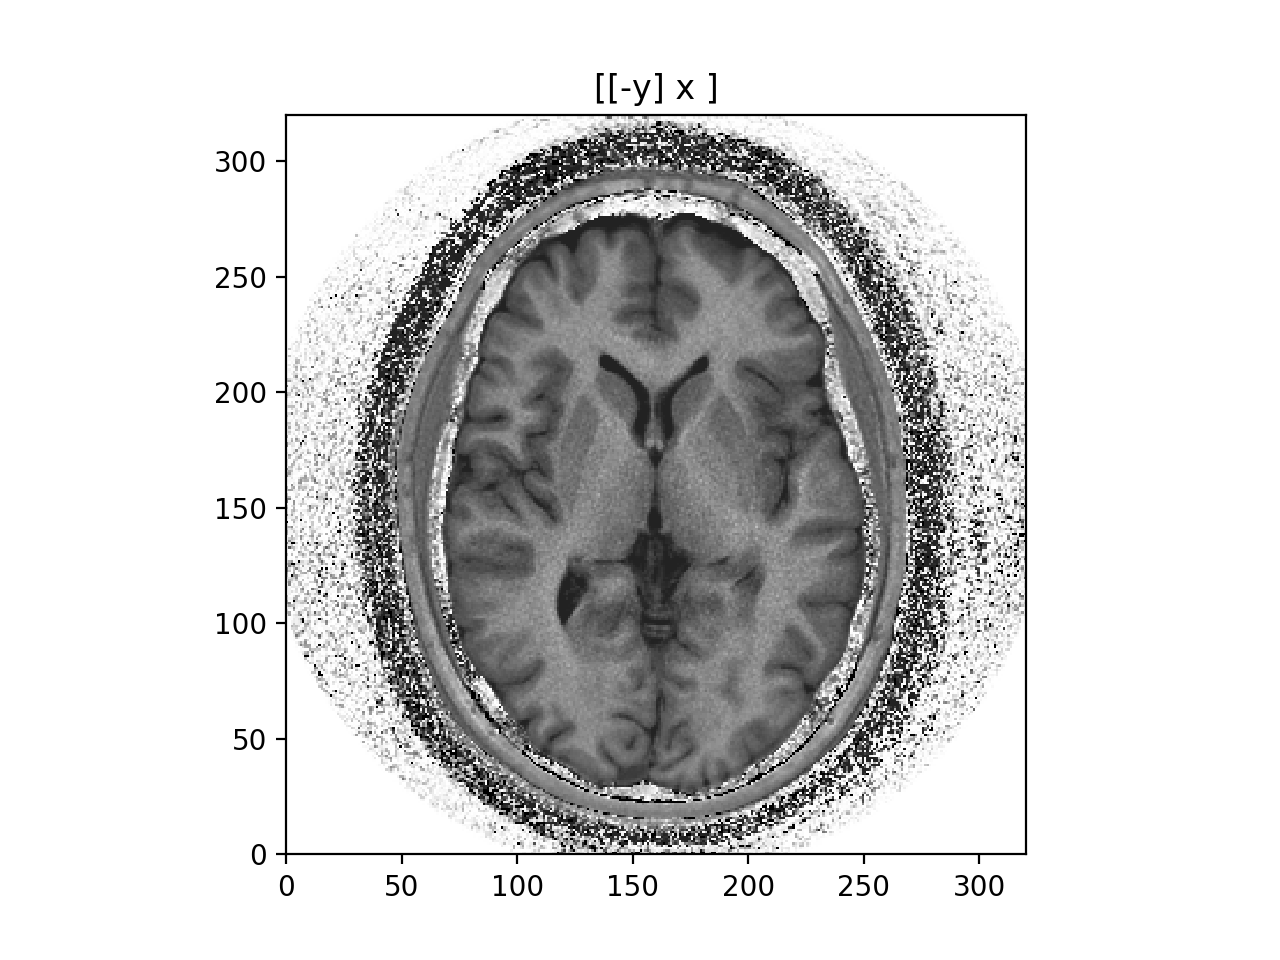

In [35]:
pl.Image(T1w_fp_epg.cpu().numpy().reshape(320,320))

In [263]:
for i in range(320):
    print(i)
    for j in range(320):
        T1 = T1_mapping[i,j]
        T2 = T2_mapping[i,j]
        T1w_fp_epg[i,j] = SE_sim(angle_ex_rad, angles_rad, TE, T1, T2, TR, B1=1.)[0]

0


/home/kewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [39]:
pd_mapping = np.load("DictionaryAndSequenceInfo/pd_mapping.npy")

<IPython.core.display.Javascript object>


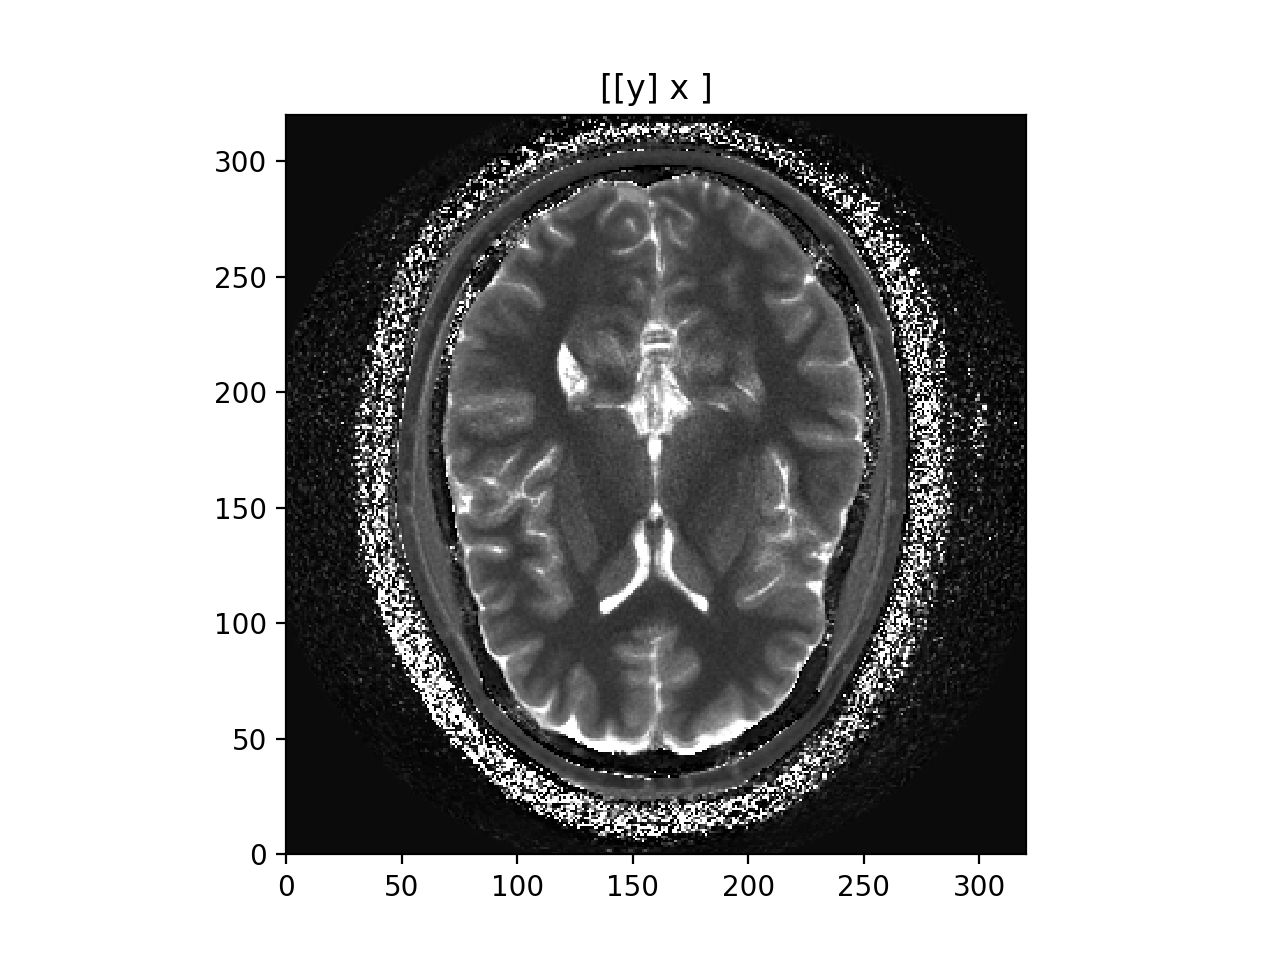

In [43]:
pl.Image(T1_mapping.numpy().reshape(320,320))

<IPython.core.display.Javascript object>


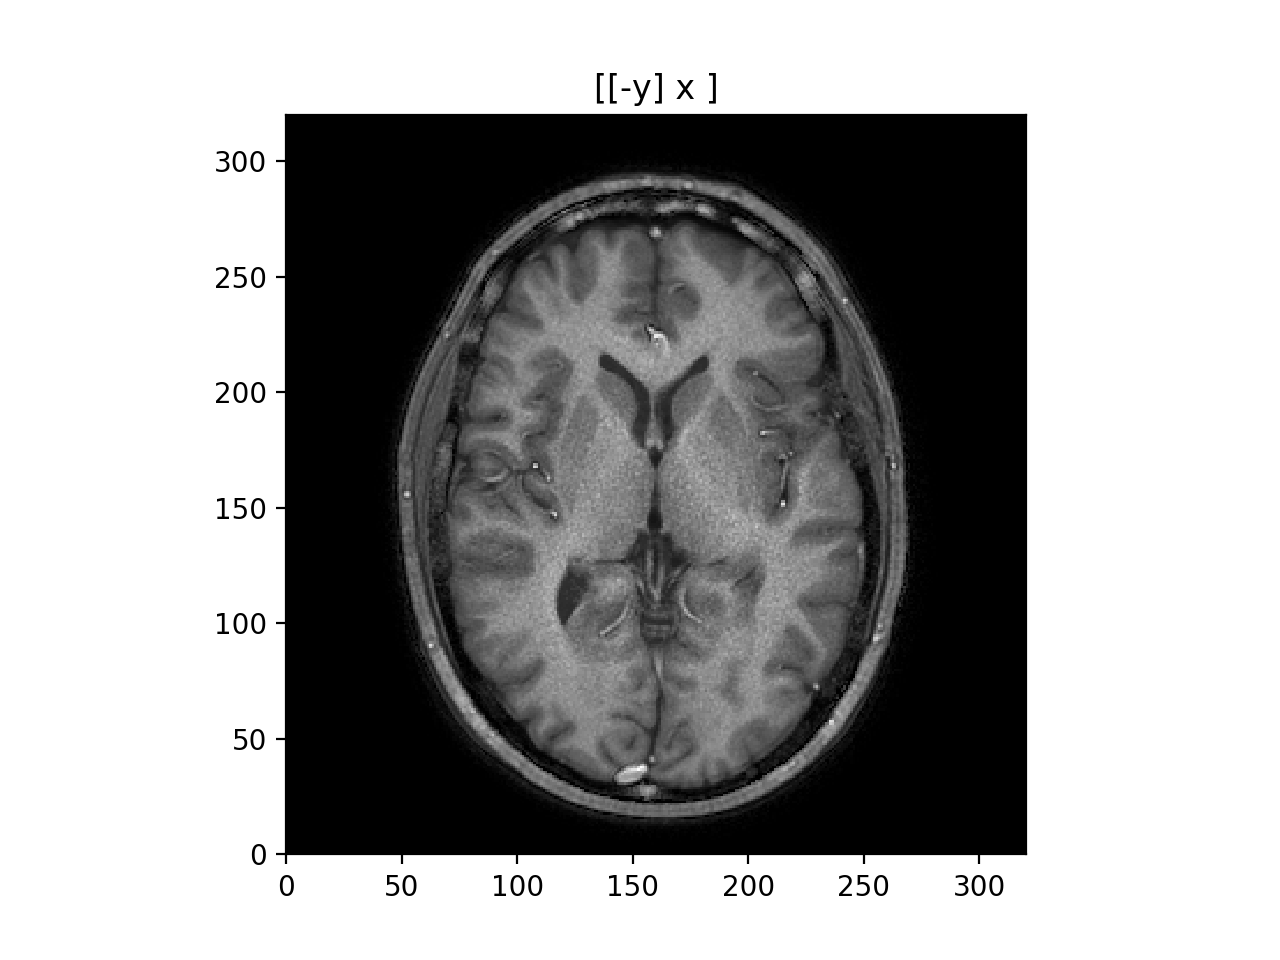

In [40]:
pl.Image(re*pd_mapping)